**1.2** Build a predictive model to estimate the likelihood of customer churn for a telecomunication company. The model should consider factors such as customer demographics,usage patterns , billing history, and customer service interactions.

In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc
import xgboost as xgb
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [ ]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

### Separate 20% of the data for testing i.e dividing in 2:8
For model evaluation on totally unseen data

In [117]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Churn'])
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4950-BDEUX,Male,0,No,No,35,No,No phone service,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,7993-NQLJE,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,7321-ZNSLA,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,...,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,4922-CVPDX,Female,0,Yes,No,26,Yes,No,DSL,No,...,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,2903-YYTBW,Male,0,Yes,Yes,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,6308-CQRBU,Female,0,Yes,No,71,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,No,Electronic check,109.25,7707.7,No
5630,2842-JTCCU,Male,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),46.05,80.35,Yes
5631,6402-ZFPPI,Female,1,No,No,25,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,102.80,2660.2,Yes
5632,3594-BDSOA,Female,0,Yes,No,24,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),20.40,482.8,No


In [118]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


None

- We can notice that 'TotalCharges' column is of wrong type

## Data Cleaning

1. **Converting 'TotalCharges' column to numeric**

In [119]:
train_df['TotalCharges'] = pd.to_numeric(train_df['TotalCharges'], errors='coerce')

2. **Check and handling missing values**

In [120]:
train_df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
Churn               0
dtype: int64

8 Null values in 'TotalCharges' column

- Fill with Mean value

In [121]:
train_df['TotalCharges'].fillna((train_df['TotalCharges'].mean()), inplace=True)

3. **Check for duplicates**

In [122]:
train_df.duplicated().sum()

0

No duplicates were found

## Exploratory Data Analysis

**Distribution of target column:**

Churn
No     4139
Yes    1495
Name: count, dtype: int64


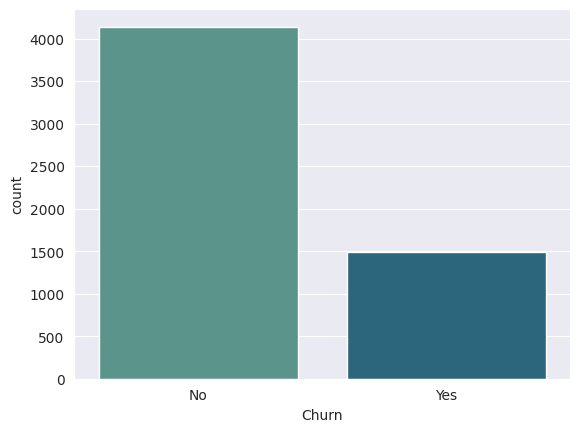

In [123]:
print(train_df['Churn'].value_counts())
_ = sns.countplot(x='Churn', data=train_df, palette='crest')

- The distribution of the binary classes shows a slight data imbalance that needs attention

**Categorical features count plot**

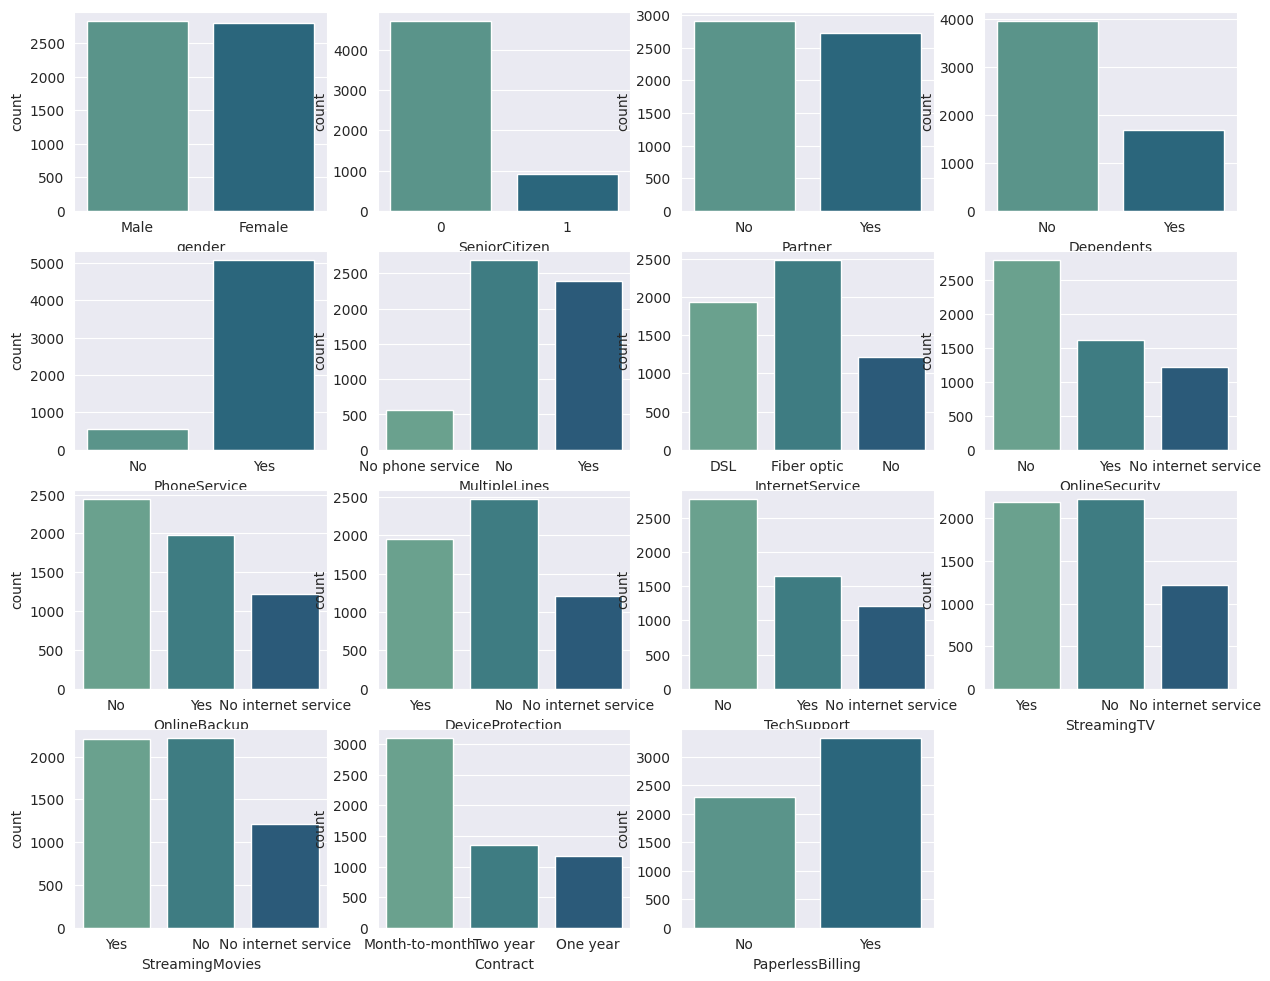

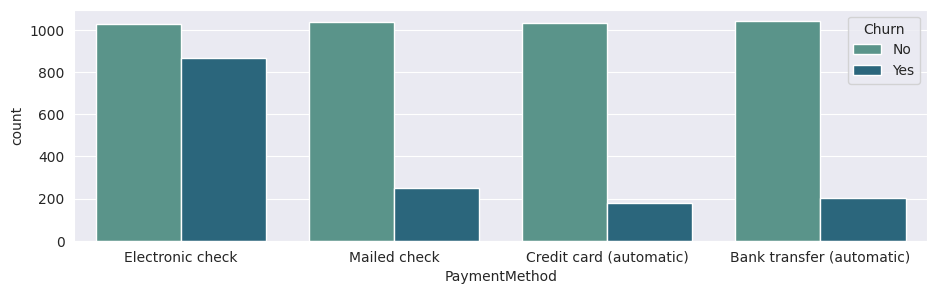

<Figure size 640x480 with 0 Axes>

In [124]:
cat_cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'Contract', 'PaperlessBilling']

plt.figure(figsize=(15, 15))
for n, variable in enumerate(cat_cols):
    ax = plt.subplot(5, 4, n + 1)
    g=sns.countplot(data=train_df, x=train_df[variable], ax=ax, palette='crest')
plt.show()
plt.figure(figsize=(11,3))
_ = sns.countplot(x= 'PaymentMethod', hue='Churn', data=train_df, palette='crest')
plt.show()
plt.tight_layout()

- The gender count plot shows an equally distribution of males and females in the dataset
- Some features have 'No' and 'No Internet Service' or 'No Phone Service' as a separate category which don't give new info and could all be considered as 'No' label

**Histogram & Boxplots of continous features**

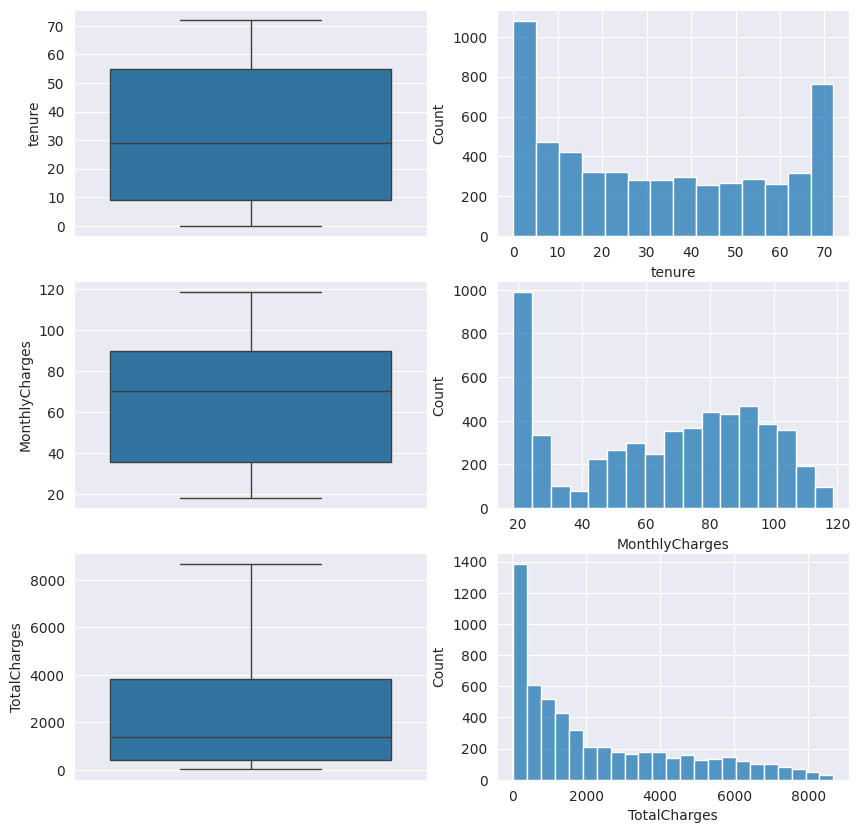

In [125]:
plt.figure(figsize=(10,10))
plt.subplot(3, 2, 1)
_ = sns.boxplot(y= train_df['tenure'])
plt.subplot(3, 2, 2)
_ = sns.histplot(x='tenure', data=train_df)

plt.subplot(3, 2, 3)
_ = sns.boxplot(y= train_df['MonthlyCharges'])
plt.subplot(3, 2, 4)
_ = sns.histplot(x='MonthlyCharges', data=train_df)

plt.subplot(3, 2, 5)
_ = sns.boxplot(y= train_df['TotalCharges'])
plt.subplot(3, 2, 6)
_ = sns.histplot(x='TotalCharges', data=train_df)

- Boxplots show that there are No outliers in the continuous variables
- Histograms show right skewness in the 'TotalCharges' feature

**Scatter plot of Monthly Charges versus Total Charges**

<Axes: xlabel='MonthlyCharges', ylabel='TotalCharges'>

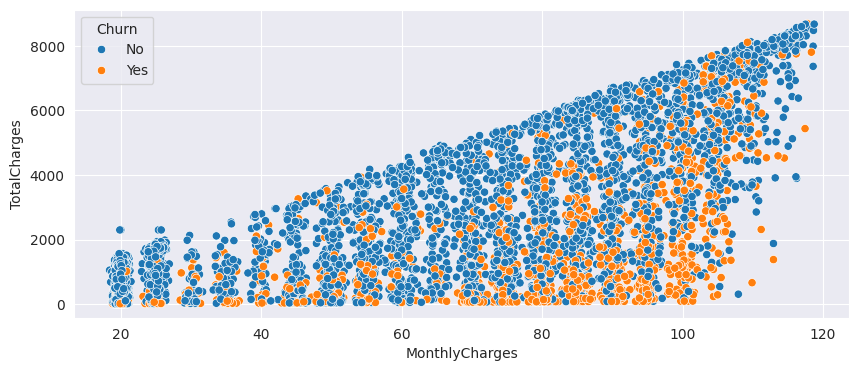

In [126]:
plt.figure(figsize=(10,4))
sns.scatterplot(data=train_df, x='MonthlyCharges', y='TotalCharges', hue='Churn')

### - This implies a positive correlation between the monthly charges, and total charges.
### - The churn rate increases with the increase in monthly charges.

**Replacing 'No internet service' and 'No phone service' with 'No'**

In [127]:
train_df.replace(['No internet service','No phone service'], 'No', inplace=True)

## Encoding categorical features
- One-Hot encoding all categorical features
- Encode by mapping target feature

In [128]:
# One-hot encoding
cat_cols = ['gender', 'InternetService','PaymentMethod','Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']

train_df = pd.concat([train_df, pd.get_dummies(train_df[cat_cols])], axis='columns')
train_df = train_df.drop(columns=cat_cols)

# mapping
train_df['Churn'] = np.where(train_df['Churn'] == 'Yes', 1, 0)  # yes=1, No=0

## Feature engineering

1. **Binning 'tenure' feature into 6 ranges**

In [129]:
condition = [((train_df.tenure >= 0)&(train_df.tenure <= 12)), ((train_df.tenure > 12)&(train_df.tenure <= 24)),
             ((train_df.tenure > 24)&(train_df.tenure <= 36)),((train_df.tenure > 36)&(train_df.tenure <= 48)),
             ((train_df.tenure > 48)&(train_df.tenure <= 60)), (train_df.tenure > 60)]

#choice = ['0-1year','1-2years', '2-3years', '3-4years','4-5years','more than 5 years']
choice = [0,1, 2, 3, 4, 5]
train_df['tenure_range'] = np.select(condition, choice)

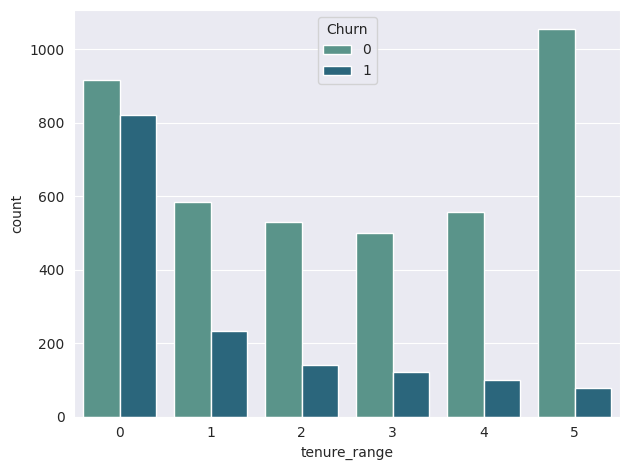

In [130]:
_ = sns.countplot(x= 'tenure_range', hue='Churn', data=train_df, palette='crest', order=choice)
plt.tight_layout()

- We can notice that customers who stay longer are more loyal to the company and very small number who leave after staying more than 4 years. On the other hand, customers churn rate is very high during the first year.

## Feature Scaling

- Log transform

In [131]:
train_df['MonthlyCharges']=np.log1p(train_df['MonthlyCharges'])
train_df['TotalCharges']=np.log1p(train_df['TotalCharges'])

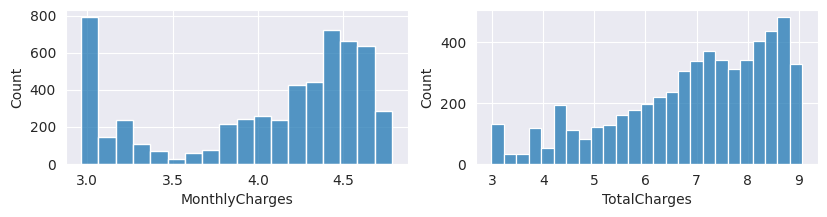

In [132]:
plt.figure(figsize=(15,2))
plt.subplot(1, 3, 2)
_ = sns.histplot(x='MonthlyCharges', data=train_df)

plt.subplot(1, 3, 3)
_ = sns.histplot(x='TotalCharges', data=train_df)

## Handling data imbalance

In [133]:
X_train = train_df.drop(columns=['customerID','Churn'])
y_train = train_df['Churn']

In [134]:
sm = SMOTE(random_state = 0, sampling_strategy = 'minority', k_neighbors= 5)
X_train, y_train = sm.fit_resample(X_train.astype(float), y_train.ravel())

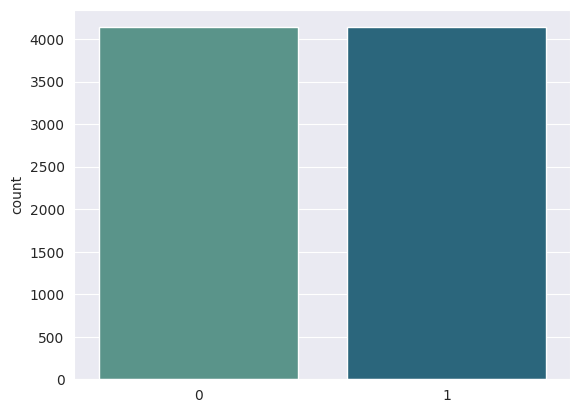

In [135]:
_ = sns.countplot(x=y_train, palette='crest')

### Preprocessing function on Test set
A function is created to apply all previous preprocessing steps on the test set

In [136]:
def test_prep (test_df):
    ### Data cleaning
    #Converting 'TotalCharges' column to numeric
    test_df['TotalCharges'] = pd.to_numeric(test_df['TotalCharges'], errors='coerce')

    #Replacing 'No internet service' and 'No phone service' with 'No'
    test_df.replace(['No internet service','No phone service'], 'No', inplace=True)

    # if there is null values in the continous features --> fill with the mean of columns in training set (mapping)
    for col in test_df.columns:
        if test_df[col].isna().sum() > 0:
            test_df[col] = test_df[col].fillna(train_df[col].map(np.mean))

    ### Categorical features encoding
    test_df = pd.concat([test_df, pd.get_dummies(test_df[cat_cols])], axis='columns')
    test_df = test_df.drop(columns=cat_cols)

    test_df['Churn'] = np.where(test_df['Churn'] == 'Yes', 1, 0)

    ### Feature engineering
    #Binning 'tenure' feature into 6 ranges
    condition = [((test_df.tenure >= 0)&(test_df.tenure <= 12)), ((test_df.tenure > 12)&(test_df.tenure <= 24)),
                 ((test_df.tenure > 24)&(test_df.tenure <= 36)),((test_df.tenure > 36)&(test_df.tenure <= 48)),
                 ((test_df.tenure > 48)&(test_df.tenure <= 60)), (test_df.tenure > 60)]
    #choice = ['0-1year','1-2years', '2-3years', '3-4years','4-5years','more than 5 years']
    choice = [0,1, 2, 3, 4, 5]
    test_df['tenure_range'] = np.select(condition, choice)

    ### Feature Scaling
    test_df['MonthlyCharges']=np.log1p(test_df['MonthlyCharges'])
    test_df['TotalCharges']=np.log1p(test_df['TotalCharges'])

    return test_df

In [137]:
test_df = test_prep(test_df)
test_df

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,...,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,tenure_range
0,4376-KFVRS,0,72,4.745367,9.044191,0,False,True,False,True,...,False,True,False,True,False,True,False,False,True,5
1,2754-SDJRD,1,8,4.616605,6.812950,0,True,False,False,True,...,False,True,False,True,False,True,True,False,False,0
2,9917-KWRBE,0,41,4.373868,8.074711,0,True,False,True,False,...,True,False,False,True,True,False,False,True,False,3
3,0365-GXEZS,0,18,4.371976,7.292848,0,False,True,False,True,...,False,True,True,False,True,False,True,False,False,1
4,9385-NXKDA,0,72,4.426641,8.686151,0,True,False,True,False,...,True,False,False,True,False,True,False,False,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,5204-HMGYF,0,49,4.479607,8.377011,0,True,False,True,False,...,False,True,False,True,False,True,False,True,False,4
1405,9950-MTGYX,0,28,3.058707,6.192260,0,False,True,False,False,...,True,False,True,False,True,False,False,False,True,2
1406,3675-EQOZA,0,5,3.075005,4.549129,0,False,True,False,False,...,True,False,True,False,True,False,True,False,False,0
1407,3646-ITDGM,0,56,3.030134,6.959304,0,True,False,False,False,...,True,False,True,False,True,False,False,False,True,4


In [138]:
X_test = test_df.drop(columns=['customerID','Churn'])
y_test = test_df['Churn']

## Model training
Trainig different models on the data to compare results of each model

1. **Logistic Regression**

In [139]:
model_logReg = LogisticRegression(C=200, max_iter=1000)

scores = cross_val_score(model_logReg, X_train, y_train, cv=10, scoring="f1")
print(scores)
model_logReg.fit(X_train, y_train)

[0.78520286 0.78384798 0.78638498 0.75970874 0.80424528 0.78780774
 0.80611046 0.79048698 0.78989667 0.77828054]


LogisticRegression(C=200, max_iter=1000)

**Testing the model**

In [ ]:
log_pred = model_logReg.predict(X_test)

- **Confusion matrix**

In [ ]:
cm = confusion_matrix(log_pred, y_test)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes']) ; ax.yaxis.set_ticklabels(['No', 'Yes'])

- **Classification report**

In [142]:
print(classification_report(y_test, log_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.90      0.73      0.81      1035
         Yes       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409

              precision    recall  f1-score   support

          No       0.90      0.73      0.81      1035
         Yes       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



## 2- SVM model

In [106]:
model_svm = SVC(kernel='linear', C=20,probability=True)
scores = cross_val_score(model_logReg, X_train, y_train, cv=10, scoring="f1")
print(scores)

model_svm.fit(X_train, y_train)

[0.78520286 0.78384798 0.78638498 0.75970874 0.80424528 0.78780774
 0.80611046 0.79048698 0.78989667 0.77828054]


SVC(C=20, kernel='linear', probability=True)

**Testing the model**

In [107]:
svm_pred = model_svm.predict(X_test)

- **Confusion matrix**

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

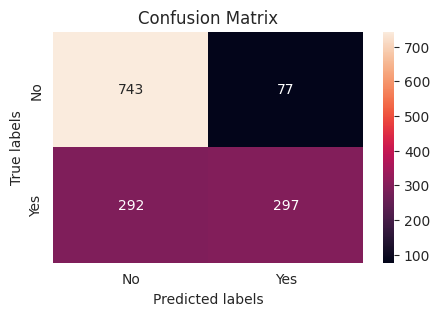

In [108]:
cm = confusion_matrix(svm_pred, y_test)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes']) ; ax.yaxis.set_ticklabels(['No', 'Yes'])

- **Classification report**

In [109]:
print(classification_report(y_test, svm_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.91      0.72      0.80      1035
         Yes       0.50      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



## 3- XGBoost model

In [110]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [1.5, 2, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [ 4, 5, 8]
        }

model_xgb = xgb.XGBClassifier(learning_rate= 0.08, n_estimators=100, objective='binary:logistic', silent=True, verbose=-1)

skf = StratifiedKFold(n_splits= 5, shuffle = True, random_state = 0)
random_search = RandomizedSearchCV(model_xgb, param_distributions=params, n_iter=5, scoring='roc_auc',
                                   n_jobs=2,cv=skf.split(X_train, y_train), verbose=-1, random_state=0)

_= random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


**Testing the model**

In [ ]:
xgb_pred = random_search.predict(X_test)

- **Confusion matrix**

In [ ]:
cm = confusion_matrix(xgb_pred, y_test)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes']) ; ax.yaxis.set_ticklabels(['No', 'Yes'])

- **Classification report**

In [ ]:
print(classification_report(y_test, xgb_pred, target_names=['No', 'Yes']))

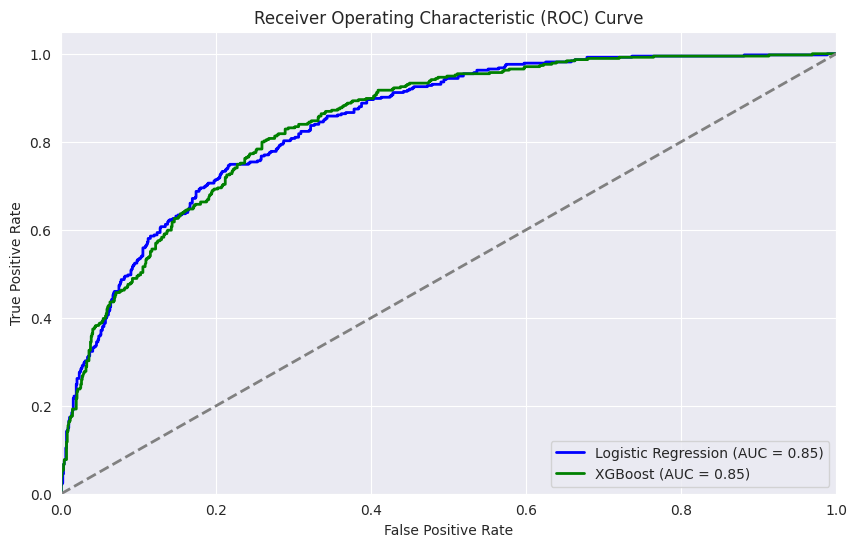

In [114]:

# ROC curve for Logistic Regression
log_pred_proba = model_logReg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_pred_proba)
roc_auc_log = auc(fpr_log, tpr_log)

# ROC curve for XGBoost
xgb_pred_proba = random_search.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [145]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Define base estimators (individual models)
estimators = [
    ('logistic_regression', model_logReg),
    ('svm', model_svm),
    ('xgboost', random_search.best_estimator_),  # Using the best XGBoost model from RandomizedSearchCV
]

# Initialize Voting Classifier with estimators
voting_clf = VotingClassifier(estimators=estimators, voting='hard')  # 'hard' voting for majority rule

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Predictions on test set
ensemble_pred = voting_clf.predict(X_test)

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.2f}")


Ensemble Model Accuracy: 0.75


Random Forest F1 Scores: [0.70868347 0.70857143 0.69653179 0.78580815 0.93592677 0.93849658
 0.93394077 0.92255892 0.92710706 0.92446449]


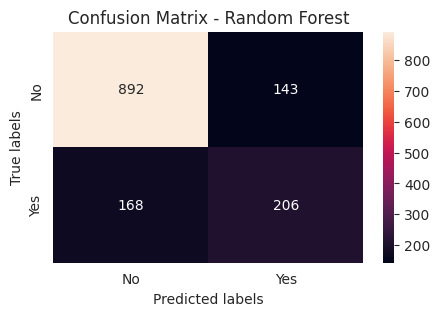

Random Forest Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.86      0.85      1035
         Yes       0.59      0.55      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.77      0.78      0.78      1409



In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
 #Train Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model_rf, X_train, y_train, cv=10, scoring="f1")
print("Random Forest F1 Scores:", scores)
model_rf.fit(X_train, y_train)
rf_pred = model_rf.predict(X_test)

# Confusion matrix for Random Forest
cm = confusion_matrix(y_test, rf_pred)
f, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Random Forest')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

# Classification report for Random Forest
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred, target_names=['No', 'Yes']))

# Perform model optimization using GridSearchCV with the Random Forest model.

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'train_df' is your training DataFrame and all preprocessing steps have been applied.

# Splitting data into features and target variable
X = train_df.drop(columns=['customerID', 'Churn'])
y = train_df['Churn']

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Make predictions on the validation set
val_pred = best_rf.predict(X_val)

# Evaluate the model on the validation set
print("Validation Classification Report:\n", classification_report(y_val, val_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, val_pred))


Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 Score: 0.5722512089392116
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87       828
           1       0.68      0.45      0.55       299

    accuracy                           0.80      1127
   macro avg       0.75      0.69      0.71      1127
weighted avg       0.79      0.80      0.79      1127

Validation Confusion Matrix:
 [[765  63]
 [163 136]]
